#### Specify Jupyter extensions

`matplotlib inline` allos visualizing the plots in the notebook.

In [1]:
%matplotlib inline

#### Import the Python libraries and custom modules as needed

In [2]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import pickle

# Import PyTorch related functions.
from torch.optim import lr_scheduler
import torchvision
import torchvision.transforms as transforms

# Import the custom module for helper functions
from utils import *

In [3]:
# Specifying seed value for reproducibility.

seedval = 8888
torch.manual_seed(seedval)

In [4]:
# Specifying project directories.

utk_imgs_path = '/dev/shm/myramdisk/crop_part1/'
adience_path = '/dev/shm/myramdisk/AdienceBenchmarkGenderAndAgeClassification/'
adience_imgs_path = '/dev/shm/myramdisk/AdienceBenchmarkGenderAndAgeClassification/faces/'

savedir = 'Data/'

modelsavedir = 'SavedModels/'

In [5]:
# Specifying the device to be used. If CUDA-enabled GPU is available, 
# the device is "cuda" else "cpu".

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Preparing the datasets

We generate training, validation, and testing splits for our gender classification model using the UTK and the Adience datasets.

In [6]:
train_df, valid_df, test_df, all_df = prepare_data(utk_imgs_path, adience_path, adience_imgs_path, seedval, True)

UTK data statistics:
6524 images 	 56.6370% females

Adience data split statistics:
valid 	 881 images 	 52.6674% females
test 	 2646 images 	 52.9101% females
train 	 8242 images 	 52.9119% females


/local-scratch2/Courses/ENSC813/Assignments/Assignment4/utils.py:304: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adience_dfs_filtered["age_simple"] = adience_dfs_filtered["age"].map(avg_age)
/local-scratch2/Courses/ENSC813/Assignments/Assignment4/utils.py:308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adience_dfs_filtered["img_path"] = (
/local-scratch2/Courses/ENSC813/Assignments/Assignment4/utils.py:317: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

### Calculating dataset statistics

In [7]:
# Create a simple PyTorch transform to begin with. We will 
# refine this as we go along.

simple_transform = transforms.Compose([
    transforms.Resize((200, 200)),
    transforms.ToTensor()])

In [8]:
# Create dataset and dataloader objects to sample from the dataset.

dset, dloader = {}, {}

dset['all'] = GenderRecognitionDataset(data_file_path=f'{savedir}/all_data.csv', 
                                       transform=simple_transform)
dloader['all'] = torch.utils.data.DataLoader(dset['all'], batch_size=1024, 
                                             shuffle=False, num_workers=2)

In [9]:
# Calculate the mean and the standard deviation of the intensity 
# values of all the images in the dataset.

dataset_mu, dataset_sigma = calculate_data_statistics(dloader['all'])
print(dataset_mu, dataset_sigma)

tensor([0.4879, 0.3768, 0.3298]) tensor([0.2469, 0.2163, 0.2000])


In [10]:
# Define dataset and dataloader objects for training, validation,
# and testing partitions and normalize the images first to [0, 1]
# using ToTensor() and then use the dataset's mean and standard
# deviation to normalize the images.

data_transform = transforms.Compose([
    transforms.Resize((200, 200)),
    transforms.ToTensor(),
    transforms.Normalize([0.4879, 0.3768, 0.3298], [0.2469, 0.2163, 0.2000])
])

dset['train'] = GenderRecognitionDataset(data_file_path=f'{savedir}/all_data_train.csv', 
                                         transform=data_transform)
dloader['train'] = torch.utils.data.DataLoader(dset['train'], batch_size=256, 
                                               shuffle=True, num_workers=1)

dset['valid'] = GenderRecognitionDataset(data_file_path=f'{savedir}/adience_data_valid.csv', 
                                         transform=data_transform)
dloader['valid'] = torch.utils.data.DataLoader(dset['valid'], batch_size=512, 
                                               shuffle=False, num_workers=1)

dset['test'] = GenderRecognitionDataset(data_file_path=f'{savedir}/adience_data_test.csv', 
                                         transform=data_transform)
dloader['test'] = torch.utils.data.DataLoader(dset['test'], batch_size=512, 
                                              shuffle=True, num_workers=1)

In [11]:
# Calculate the sizes of training, validation, and testing partitions.
# This is used to calculate mean loss and accuracy values.

dset_sizes = {x: len(dset[x]) for x in ['train', 'valid', 'test']}
print(dset_sizes)

{'train': 14766, 'valid': 881, 'test': 2646}


## Logistic Regression

We will begin by using a single neuron logistic regression classifier for gender classification.

In [12]:
# The input dimensionality for 200 x 200 RGB images is 200 x 200 x 3,
# since each of the 3 R, G, and B channels has 200 x 200 values.

input_dim = 3*200*200

# Instantiate the model and move it to the specified device.
model1 = LogisticRegression(input_dim)
model1 = model1.to(device)

# Specify the loss function to be used and move it to the specified 
# device.
# We use the BCEWithLogitsLoss() here since it is a binary 
# classification task and we do not use softmax activation on the 
# model's outputs. 
criterion = nn.BCEWithLogitsLoss()
criterion.to(device)

# Specify the optimizer and the learning rate scheduler.
# We use stochastic gradient descent (SGD) with learning rate = 1e-3
# and momentum=0.9 to optimize our model.
# For the learning rate scheduler, we use an exponential step-wise
# decay, where the learning rate becomes one-tenth of its previous
# value after every 10 optimizer steps.
optimizer_ft = optim.SGD(model1.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.1)

In [13]:
# Train the logistic regression model.

model1, losses, accs = train_model(model1, dloader, dset_sizes, criterion, 
                                   optimizer_ft, exp_lr_scheduler, 30, 'cuda', True)

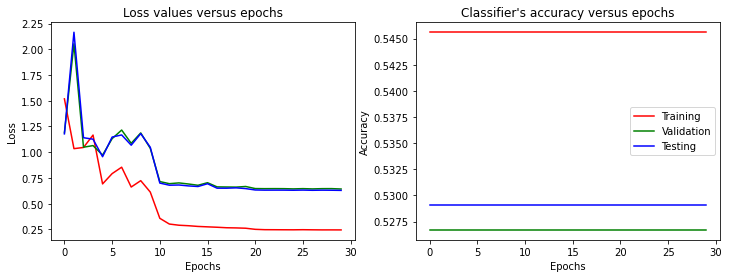

In [14]:
# Visualizing the model's loss values and classification accuracy.

fig, axs = plt.subplots(1, 2, figsize=(12, 4), sharex=True)

axs[0].plot(losses['train'], 'r', label='Training')
axs[0].plot(losses['valid'], 'g', label='Validation')
axs[0].plot(losses['test'], 'b', label='Testing')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].title.set_text('Loss values versus epochs')

axs[1].plot(accs['train'], 'r', label='Training')
axs[1].plot(accs['valid'], 'g', label='Validation')
axs[1].plot(accs['test'], 'b', label='Testing')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].title.set_text('Classifier\'s accuracy versus epochs')

plt.legend()
plt.savefig(savedir + 'LogReg_plots.png', dpi=300, bbox_inches='tight')
plt.show()

## FCN model

Next, we train a fully connected network (FCN) model which has one hidden layer. Therefore, this is a shallow neural network model.

In [15]:
# As described before, the input dimensionality for 200 x 200
# RGB images is 200 x 200 x 3.

FCN_input_dim = 3*200*200

# In order to choose the optimal number of neurons in the 
# hidden layer, we train models using several possible choices
# and then use the one which yields the highest validation
# accuracy.

hidden_dim_vals = [50, 100, 500, 1000]

In [16]:
# For all values of hidden layer dimensionality, train a model 
# and save model weights, losses, and accuracies.

for hidden_dim in hidden_dim_vals:
    model2 = FCN(FCN_input_dim, hidden_dim, 2)
    model2 = model2.to(device)

    criterion = nn.CrossEntropyLoss()
    criterion.to(device)
    optimizer_ft = optim.SGD(model2.parameters(), lr=0.01, momentum=0.9)
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.1)

    model2, losses, accs = train_model(model2, dloader, dset_sizes, criterion, 
                                       optimizer_ft, exp_lr_scheduler, 30, 'cuda')

    # Calculate the confusion matrix for each model on the test 
    # dataset.
    # Remember that this is calculated after the model training
    # is completed, so there is no data leakage from the test 
    # set.
    confmat = calculate_confmat(model2, dloader, 'cuda')

    # Save the model weights and the training related statistics.
    torch.save(model2, f'{modelsavedir}/FCN_model_{hidden_dim}.pth')
    training_stats = {'losses':losses, 'accs':accs, 'confmat':confmat}
    with open(f'{modelsavedir}/FCN_results_{hidden_dim}.pickle', 'wb') as handle:
        pickle.dump(training_stats, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [17]:
# Load and parse all models to choose the best model.

FCN_dir = f'{modelsavedir}/FCN_models/'

FCN_confmats = [f for f in os.listdir(FCN_dir) if ('FCN_' in f and f.endswith('.pickle'))]

In [18]:
# Initialize variables to find the best performing 
# model and to find the corresponding validation and
# test accuracies.

best_valid_exp, best_valid_acc, test_acc = None, 0., 0.
valid_scores = np.zeros(len(FCN_confmats))

# For each model's training statistics, find the 
# model with the highest validation accuracy and
# then report that model's test accuracy.
for idx, FCN_confmat in enumerate(FCN_confmats):
    with open(f'{FCN_dir}/{FCN_confmat}', 'rb') as handle:
        tmp_res = pickle.load(handle)
    valid_scores[idx] = tmp_res['accs']['valid'].max().item()
    if valid_scores[idx] > best_valid_acc:
        best_valid_exp, best_valid_acc = FCN_confmat, tmp_res['accs']['valid'].max().item()
        tmp_cm = tmp_res['confmat']
        test_acc, test_cm = (tmp_cm.trace() / tmp_cm.sum()).item(), tmp_res['confmat']

print(f'Best model: {best_valid_exp} -> val acc: {best_valid_acc:.4f}; test acc: {test_acc:.4f}')
print(f'Confusion matrix: \n{test_cm}')

Best model: FCN_results_50.pickle -> val acc: 0.8434; test acc: 0.8288
Confusion matrix: 
tensor([[1018.,  228.],
        [ 225., 1175.]])


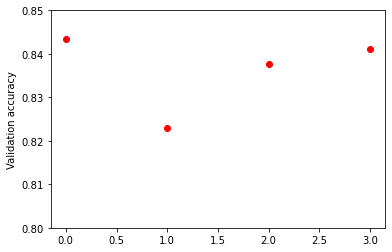

In [19]:
# Visualize the validation accuracy of all the models.

valid_scores = np.array([0.84335983, 0.8229, 0.8376, 0.8410])
plt.plot(valid_scores, 'r.', markersize=12)
plt.ylim([0.8, 0.85])
plt.ylabel('Validation accuracy')
plt.savefig(savedir + 'FCN_validation.png', dpi=300, bbox_inches='tight')

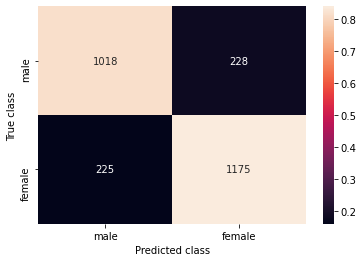

In [20]:
# Normalize the confusion matrix row-wise so that each row
# is colored according to the number of data points 
# predicted.
fcn_confmat = test_cm.cpu().numpy()
fcn_confmat_norm = fcn_confmat.T / fcn_confmat.sum(axis=1).T
fcn_confmat_norm = fcn_confmat_norm.T

# Set x-tick and y-tick labels for the plot.
confmat_ticklabels = ['male', 'female']

# Create a seaborn heatmap to visualize the confusion matrix
# of the classifier on the test set.
# fmt="g" enforces integer output in each cell.
confmat_heatmap = sns.heatmap(fcn_confmat_norm, 
                              annot=fcn_confmat, 
                              fmt="g", 
                              xticklabels=confmat_ticklabels, 
                              yticklabels=confmat_ticklabels)

# Set axis labels for the confusion matrix.
confmat_heatmap.set(xlabel="Predicted class",
                    ylabel="True class")

confmat_fig = confmat_heatmap.get_figure()    
confmat_fig.savefig(savedir + 'FCN_best_confmat.png', dpi=300, bbox_inches='tight')

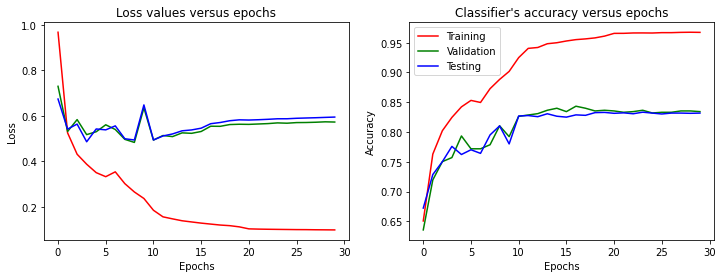

In [21]:
# Plotting the best classifier's loss and accuracy over the 
# course of training.

with open(f'{FCN_dir}/{best_valid_exp}', 'rb') as handle:
        best_res = pickle.load(handle)

fig, axs = plt.subplots(1, 2, figsize=(12, 4), sharex=True)

axs[0].plot(best_res['losses']['train'], 'r', label='Training')
axs[0].plot(best_res['losses']['valid'], 'g', label='Validation')
axs[0].plot(best_res['losses']['test'], 'b', label='Testing')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].title.set_text('Loss values versus epochs')

axs[1].plot(best_res['accs']['train'], 'r', label='Training')
axs[1].plot(best_res['accs']['valid'], 'g', label='Validation')
axs[1].plot(best_res['accs']['test'], 'b', label='Testing')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].title.set_text('Classifier\'s accuracy versus epochs')

plt.legend()
plt.savefig(savedir + 'FCN_best_plots.png', dpi=300, bbox_inches='tight')
plt.show()

### Improving the generalization performance

In order to improve the generalization performance, we try to add data augmentation in the form of geometric transformations to the training images as well as regularization for the fully connected layers in the form of dropout. Dropout is justified since the number of parameters of this model is orders of magnitude larger than the number of training images, which means that it is easy for the model to overfit to the training data.

In [22]:
# Update the dataset and dataloader objects for training to 
# incorporate the geometric augmentation techniques.

advanced_transform = transforms.Compose([
    transforms.Resize((200, 200)),
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.4879, 0.3768, 0.3298], [0.2469, 0.2163, 0.2000])
])

dset['train'] = GenderRecognitionDataset(data_file_path=f'{savedir}/all_data_train.csv', 
                                         transform=advanced_transform)
dloader['train'] = torch.utils.data.DataLoader(dset['train'], batch_size=256, 
                                               shuffle=True, num_workers=1)

In [23]:
# Instantiate the model and move it to the specified device.
# Note that we are using a modified version of FCN which has
# a Dropout layer added for regularization. It is important 
# to point out that this model has the same number of 
# trainable parameters and is architecturally the same at 
# inference time as the model without Dropout.

model2 = FCN_Dropout(FCN_input_dim, 50, 2)
model2 = model2.to(device)
            
# Specify the loss function to be used and move it to the specified 
# device.

criterion = nn.CrossEntropyLoss()
criterion.to(device)

# Specify the optimizer and the learning rate scheduler.

optimizer_ft = optim.SGD(model2.parameters(), lr=0.01, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.1)

# Train the classification model.

model2, losses, accs = train_model(model2, dloader, dset_sizes, criterion, 
                                   optimizer_ft, exp_lr_scheduler, 30, 'cuda')

# Aggregate the training related statistics in a dictionary.

confmat = calculate_confmat(model2, dloader, 'cuda')
best_res = {'losses':losses, 'accs':accs, 'confmat':confmat}

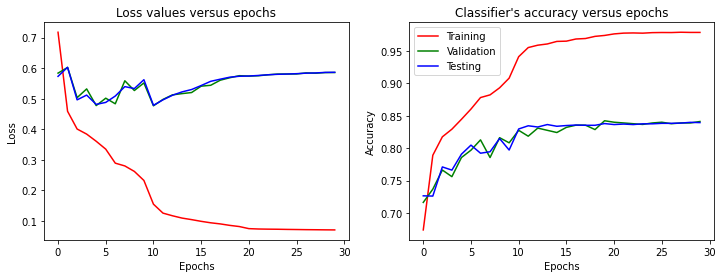

In [24]:
# Plotting the improved classifier's loss and accuracy over  
# the course of training.

fig, axs = plt.subplots(1, 2, figsize=(12, 4), sharex=True)

axs[0].plot(best_res['losses']['train'], 'r', label='Training')
axs[0].plot(best_res['losses']['valid'], 'g', label='Validation')
axs[0].plot(best_res['losses']['test'], 'b', label='Testing')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].title.set_text('Loss values versus epochs')

axs[1].plot(best_res['accs']['train'], 'r', label='Training')
axs[1].plot(best_res['accs']['valid'], 'g', label='Validation')
axs[1].plot(best_res['accs']['test'], 'b', label='Testing')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].title.set_text('Classifier\'s accuracy versus epochs')

plt.legend()
plt.savefig(savedir + 'FCN_improved_plots.png', dpi=300, bbox_inches='tight')
plt.show()

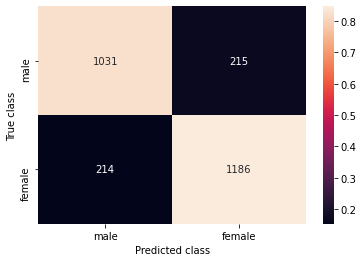

In [25]:
# Normalize the confusion matrix row-wise so that each row
# is colored according to the number of data points 
# predicted.
fcn_confmat = best_res['confmat'].cpu().numpy()
fcn_confmat_norm = fcn_confmat.T / fcn_confmat.sum(axis=1).T
fcn_confmat_norm = fcn_confmat_norm.T

# Set x-tick and y-tick labels for the plot.
confmat_ticklabels = ['male', 'female']

# Create a seaborn heatmap to visualize the confusion matrix
# of the classifier on the test set.
# fmt="g" enforces integer output in each cell.
confmat_heatmap = sns.heatmap(fcn_confmat_norm, 
                              annot=fcn_confmat, 
                              fmt="g", 
                              xticklabels=confmat_ticklabels, 
                              yticklabels=confmat_ticklabels)

# Set axis labels for the confusion matrix.
confmat_heatmap.set(xlabel="Predicted class",
                    ylabel="True class")

confmat_fig = confmat_heatmap.get_figure()    
confmat_fig.savefig(savedir + 'FCN_improved_confmat.png', dpi=300, bbox_inches='tight')

## CNN model

Finally, we train a convolutional neural network (CNN) model which has two convolutional layers and one fully connected layer.

In [26]:
# Reverting to the original dataset and dataloader objects.

dset['train'] = GenderRecognitionDataset(data_file_path=f'{savedir}/all_data_train.csv', 
                                         transform=data_transform)
dloader['train'] = torch.utils.data.DataLoader(dset['train'], batch_size=256, 
                                               shuffle=True, num_workers=1)

In [27]:
# In order to choose the optimal number of filters (or channels),
# the size of the filters, and the number of neurons in the fully
# connected layer, we train models using several possible choices
# and then use the one which yields the highest validation
# accuracy.

filter1_vals = filter2_vals = [3, 5]
n_channels_vals = [4, 6, 8, 16]
fc_dim_vals = [100, 500]

In [28]:
# For all values of architectural hyperparameters, train a model 
# and save model weights, losses, and accuracies.

for filter1 in filter1_vals:
    for filter2 in filter2_vals:
        for n_channels in n_channels_vals:
            for fc_dim in fc_dim_vals:
                model3 = CNN(filter1, filter2, n_channels, fc_dim, 2)
                model3 = model3.to(device)

                criterion = nn.CrossEntropyLoss()
                criterion.to(device)
                optimizer_ft = optim.SGD(model3.parameters(), lr=0.01, momentum=0.9)
                exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.1)

                model3, losses, accs = train_model(model3, dloader, dset_sizes, criterion, 
                                                   optimizer_ft, exp_lr_scheduler, 30, 'cuda')

                # Calculate the confusion matrix for each model on the test 
                # dataset.
                # Remember that this is calculated after the model training
                # is completed, so there is no data leakage from the test 
                # set.
                
                confmat = calculate_confmat(model3, dloader, 'cuda')

                # Save the model weights and the training related statistics.
                
                torch.save(model3, f'{modelsavedir}/CNN_model_{filter1}_{filter2}_{n_channels}_{fc_dim}.pth')
                training_stats = {'losses':losses, 'accs':accs, 'confmat':confmat}
                with open(f'{modelsavedir}/CNN_results_{filter1}_{filter2}_{n_channels}_{fc_dim}.pickle', 'wb') as handle:
                    pickle.dump(training_stats, handle, protocol=pickle.HIGHEST_PROTOCOL)

/local-scratch/localhome/kabhishe/Installations/miniconda3/envs/pytorch/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448278899/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [29]:
# Load and parse all models to choose the best model.

CNN_dir = f'{modelsavedir}/CNN_models/'

CNN_confmats = [f for f in os.listdir(CNN_dir) if ('CNN_' in f and f.endswith('.pickle'))]

In [30]:
# Initialize variables to find the best performing 
# model and to find the corresponding validation and
# test accuracies.

best_valid_exp, best_valid_acc, test_acc = None, 0., 0.
valid_scores = np.zeros(len(CNN_confmats))

# For each model's training statistics, find the 
# model with the highest validation accuracy and
# then report that model's test accuracy.

for idx, CNN_confmat in enumerate(CNN_confmats):
    with open(f'{CNN_dir}/{CNN_confmat}', 'rb') as handle:
        tmp_res = pickle.load(handle)
    valid_scores[idx] = tmp_res['accs']['valid'].max().item()
    if valid_scores[idx] > best_valid_acc:
        best_valid_exp, best_valid_acc = CNN_confmat, tmp_res['accs']['valid'].max().item()
        tmp_cm = tmp_res['confmat']
        test_acc, test_cm = (tmp_cm.trace() / tmp_cm.sum()).item(), tmp_res['confmat']
        
print(f'Best model: {best_valid_exp} -> val acc: {best_valid_acc:.4f}; test acc: {test_acc:.4f}')
print(f'Confusion matrix: \n{test_cm}')

Best model: CNN_results_5_5_16_500.pickle -> val acc: 0.8956; test acc: 0.8760
Confusion matrix: 
tensor([[1090.,  156.],
        [ 172., 1228.]])


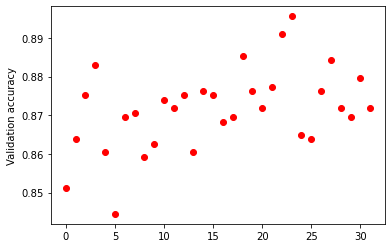

In [31]:
# Visualize the validation accuracy of all the models.

plt.plot(valid_scores, 'r.', markersize=12)
plt.ylabel('Validation accuracy')
plt.savefig(savedir + 'CNN_validation.png', dpi=300, bbox_inches='tight')

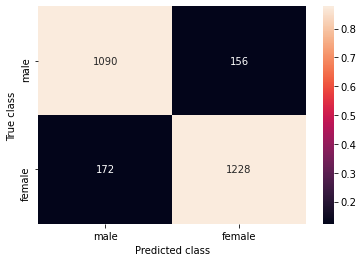

In [32]:
# Normalize the confusion matrix row-wise so that each row
# is colored according to the number of data points 
# predicted.
cnn_confmat = test_cm.cpu().numpy()
cnn_confmat_norm = cnn_confmat.T / cnn_confmat.sum(axis=1).T
cnn_confmat_norm = cnn_confmat_norm.T

# Set x-tick and y-tick labels for the plot.
confmat_ticklabels = ['male', 'female']

# Create a seaborn heatmap to visualize the confusion matrix
# of the classifier on the test set.
# fmt="g" enforces integer output in each cell.
confmat_heatmap = sns.heatmap(cnn_confmat_norm, 
                              annot=cnn_confmat, 
                              fmt="g", 
                              xticklabels=confmat_ticklabels, 
                              yticklabels=confmat_ticklabels)

# Set axis labels for the confusion matrix.
confmat_heatmap.set(xlabel="Predicted class",
                    ylabel="True class")

confmat_fig = confmat_heatmap.get_figure()    
confmat_fig.savefig(savedir + 'CNN_best_confmat.png', dpi=300, bbox_inches='tight')

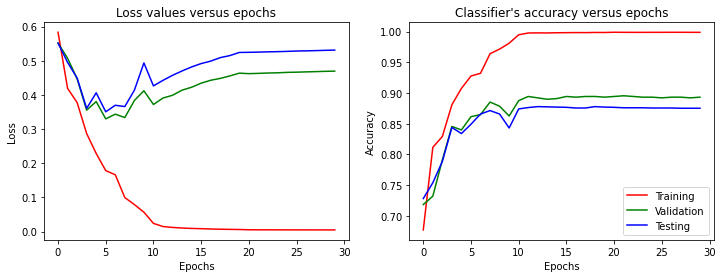

In [33]:
# Plotting the best classifier's loss and accuracy over the 
# course of training.

with open(f'{CNN_dir}/{best_valid_exp}', 'rb') as handle:
        best_res = pickle.load(handle)

fig, axs = plt.subplots(1, 2, figsize=(12, 4), sharex=True)

axs[0].plot(best_res['losses']['train'], 'r', label='Training')
axs[0].plot(best_res['losses']['valid'], 'g', label='Validation')
axs[0].plot(best_res['losses']['test'], 'b', label='Testing')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].title.set_text('Loss values versus epochs')

axs[1].plot(best_res['accs']['train'], 'r', label='Training')
axs[1].plot(best_res['accs']['valid'], 'g', label='Validation')
axs[1].plot(best_res['accs']['test'], 'b', label='Testing')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].title.set_text('Classifier\'s accuracy versus epochs')

plt.legend()
plt.savefig(savedir + 'CNN_best_plots.png', dpi=300, bbox_inches='tight')
plt.show()

### Improving the generalization performance

In order to improve the generalization performance, we try to add data augmentation in the form of geometric transformations to the training images. Given that we are using convolutional neural networks which are able to learn increasingly complex spatial patterns in images as we use more layers, increasing the variety of inputs would lead to the model learning more diverse sets of features.

In [34]:
# Update the dataset and dataloader objects for training to 
# incorporate the geometric augmentation techniques.

advanced_transform = transforms.Compose([
    transforms.Resize((200, 200)),
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.4879, 0.3768, 0.3298], [0.2469, 0.2163, 0.2000])
])

dset['train'] = GenderRecognitionDataset(data_file_path=f'{savedir}/all_data_train.csv', 
                                         transform=advanced_transform)
dloader['train'] = torch.utils.data.DataLoader(dset['train'], batch_size=256, 
                                               shuffle=True, num_workers=1)

In [35]:
# Instantiate the model and move it to the specified device.

model3 = CNN(5, 5, 16, 500, 2)
model3 = model3.to(device)
            
# Specify the loss function to be used and move it to the specified 
# device.

criterion = nn.CrossEntropyLoss()
criterion.to(device)

# Specify the optimizer and the learning rate scheduler.

optimizer_ft = optim.SGD(model3.parameters(), lr=0.01, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.1)

model3, losses, accs = train_model(model3, dloader, dset_sizes, criterion, 
                                   optimizer_ft, exp_lr_scheduler, 30, 'cuda')

# Aggregate the training related statistics in a dictionary.

confmat = calculate_confmat(model3, dloader, 'cuda')

torch.save(model3, f'{modelsavedir}/Best_CNN_model_5_5_16_500.pth')
training_stats = {'losses':losses, 'accs':accs, 'confmat':confmat}
with open(f'{modelsavedir}/Best_CNN_results_5_5_16_500.pickle', 'wb') as handle:
    pickle.dump(training_stats, handle, protocol=pickle.HIGHEST_PROTOCOL)

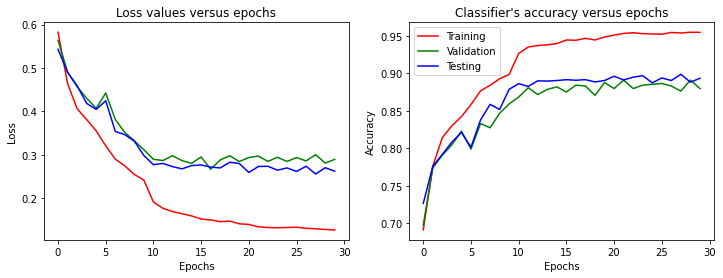

In [36]:
# Plotting the improved classifier's loss and accuracy over  
# the course of training.

with open(f'{modelsavedir}/Best_CNN_results_5_5_16_500.pickle', 'rb') as handle:
        best_res = pickle.load(handle)
        
fig, axs = plt.subplots(1, 2, figsize=(12, 4), sharex=True)

axs[0].plot(best_res['losses']['train'], 'r', label='Training')
axs[0].plot(best_res['losses']['valid'], 'g', label='Validation')
axs[0].plot(best_res['losses']['test'], 'b', label='Testing')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].title.set_text('Loss values versus epochs')

axs[1].plot(best_res['accs']['train'], 'r', label='Training')
axs[1].plot(best_res['accs']['valid'], 'g', label='Validation')
axs[1].plot(best_res['accs']['test'], 'b', label='Testing')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].title.set_text('Classifier\'s accuracy versus epochs')

plt.legend()
plt.savefig(savedir + 'CNN_improved_plots.png', dpi=300, bbox_inches='tight')
plt.show()

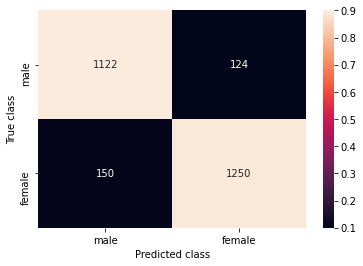

In [37]:
# Normalize the confusion matrix row-wise so that each row
# is colored according to the number of data points 
# predicted.
cnn_confmat = best_res['confmat'].cpu().numpy()
cnn_confmat_norm = cnn_confmat.T / cnn_confmat.sum(axis=1).T
cnn_confmat_norm = cnn_confmat_norm.T

# Set x-tick and y-tick labels for the plot.
confmat_ticklabels = ['male', 'female']

# Create a seaborn heatmap to visualize the confusion matrix
# of the classifier on the test set.
# fmt="g" enforces integer output in each cell.
confmat_heatmap = sns.heatmap(cnn_confmat_norm, 
                              annot=cnn_confmat, 
                              fmt="g", 
                              xticklabels=confmat_ticklabels, 
                              yticklabels=confmat_ticklabels)

# Set axis labels for the confusion matrix.
confmat_heatmap.set(xlabel="Predicted class",
                    ylabel="True class")

confmat_fig = confmat_heatmap.get_figure()    
confmat_fig.savefig(savedir + 'CNN_improved_confmat.png', dpi=300, bbox_inches='tight')